In [64]:
import sys
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.metrics import make_scorer, accuracy_score, r2_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC, SVR

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

In [39]:
# Read in the test data. This will have already been preprocessed by the preprocessing engine
file_path = '/Users/danmcgill/Desktop/SWENG 894/repos/sweng-capstone-project/test-data/IRIS.csv'
df = pd.read_csv(file_path)
print(df.head())

   sepal_length  sepal_width  petal_length  petal_width      species
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa


In [60]:
# this data set has non-numeric categories, lets make a numeric label column
df['species_numeric'] = df['species'].astype('category').cat.codes
label_names = df['species'].astype('category').cat.categories # save this so later we can make conf matrix
print(df[['species', 'species_numeric']].drop_duplicates())

             species  species_numeric
0        Iris-setosa                0
50   Iris-versicolor                1
100   Iris-virginica                2


In [41]:
# assuming weve been provided the target column:
target_column = 'species_numeric'
X = df.drop(columns=['species', target_column])  # we know we have to drop species here too
y = df[target_column]
print("Features:")
print(X.head())
print("Target:")
print(y.head())

Features:
   sepal_length  sepal_width  petal_length  petal_width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2
Target:
0    0
1    0
2    0
3    0
4    0
Name: species_numeric, dtype: int8


In [42]:
# assuming the scaling will be done in the preprocessing step:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
print(X_scaled_df.head())

   sepal_length  sepal_width  petal_length  petal_width
0      0.222222     0.625000      0.067797     0.041667
1      0.166667     0.416667      0.067797     0.041667
2      0.111111     0.500000      0.050847     0.041667
3      0.083333     0.458333      0.084746     0.041667
4      0.194444     0.666667      0.067797     0.041667


In [43]:
# now that we know its scaled, split into test and train. 
# this will have also been done in preprocessing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [44]:
# task type will likely be user input
task_type = 'classification' # or regression

if task_type == 'classification':
    models = {
        'LogisticRegression': LogisticRegression(max_iter=1000),
        'RandomForestClassifier': RandomForestClassifier(),
        'GradientBoostingClassifier': GradientBoostingClassifier(),
        'SVC': SVC()
    }
else:
    models = {
        'LinearRegression': LinearRegression(),
        'RandomForestRegressor': RandomForestRegressor(),
        'GradientBoostingRegressor': GradientBoostingRegressor(),
        'SVR': SVR()
    }

print(list(models.keys()))

['LogisticRegression', 'RandomForestClassifier', 'GradientBoostingClassifier', 'SVC']


In [45]:
# use cross fold validation to evaluate how each model performs
scoring = 'accuracy' if task_type == 'classification' else 'r2'

cv_folds = 5

model_scores = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring=scoring)
    model_scores[name] = scores
    print(f"{name} CV {scoring}: Mean={scores.mean():.3f} Std={scores.std():.3f}")

best_model_name = max(model_scores, key=lambda k: model_scores[k].mean())
print(f"\nBest model: {best_model_name} with mean {scoring} = {model_scores[best_model_name].mean():.3f}")

LogisticRegression CV accuracy: Mean=0.908 Std=0.067
RandomForestClassifier CV accuracy: Mean=0.958 Std=0.046
GradientBoostingClassifier CV accuracy: Mean=0.950 Std=0.041
SVC CV accuracy: Mean=0.958 Std=0.046

Best model: RandomForestClassifier with mean accuracy = 0.958


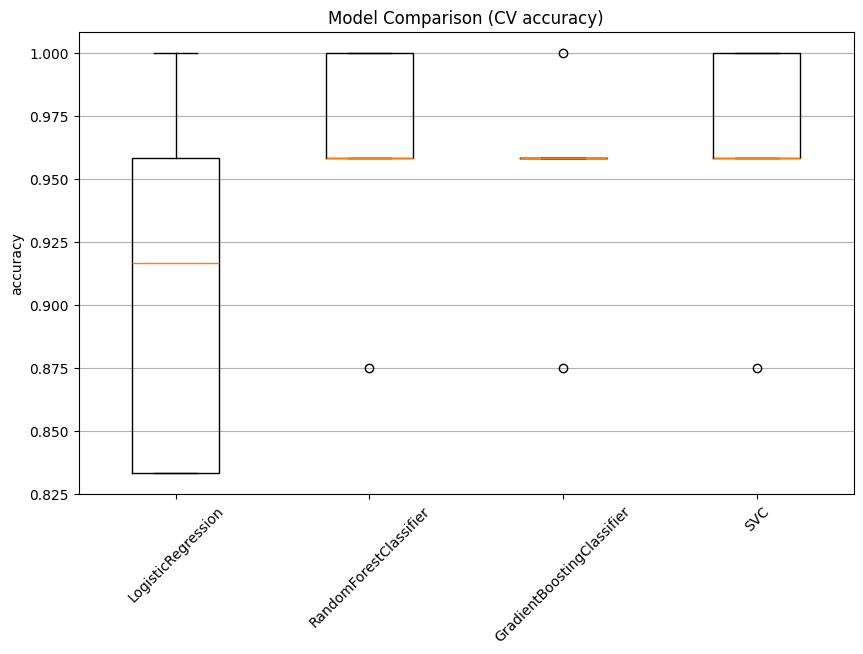

In [46]:
# potentially add a graphic to the report:
plt.figure(figsize=(10, 6))
plt.boxplot(model_scores.values(), tick_labels=model_scores.keys())
plt.title(f'Model Comparison (CV {scoring})')
plt.ylabel(scoring)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [47]:
# define the parameter grid for fine tuning the model: 
param_grids = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs']
    },
    'RandomForestClassifier': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20]
    },
    'GradientBoostingClassifier': {
        'learning_rate': [0.01, 0.1],
        'n_estimators': [50, 100]
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'LinearRegression': {
    },
    'RandomForestRegressor': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'GradientBoostingRegressor': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    },
    'SVR': {
        'kernel': ['linear', 'rbf'],
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto']
    }
}

In [55]:
# instantiate an untrained version of the best model

# fake the best model for each model:
# best_model_name = 'SVC'
# 'LogisticRegression'
# 'RandomForestClassifier'
# 'GradientBoostingClassifier'
# 'SVC'
best_model = models[best_model_name]

# get the param grid from the saved list
param_grid = param_grids.get(best_model_name, {})

# run the grid search
grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring=scoring, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best params for {best_model_name}: {grid_search.best_params_}")
print(f"Best CV {scoring} from GridSearch: {grid_search.best_score_}")

optimized_model = grid_search.best_estimator_

Best params for SVC: {'C': 1, 'kernel': 'rbf'}
Best CV accuracy from GridSearch: 0.9583333333333334


In [56]:
# selection complete, train the optimized, best model
optimized_model.fit(X_train, y_train)

y_train_pred = optimized_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
y_pred = optimized_model.predict(X_test)
test_score = accuracy_score(y_test, y_pred)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy of the final model: {test_score:.4f}")

Train Accuracy: 0.9750
Test Accuracy of the final model: 1.0000


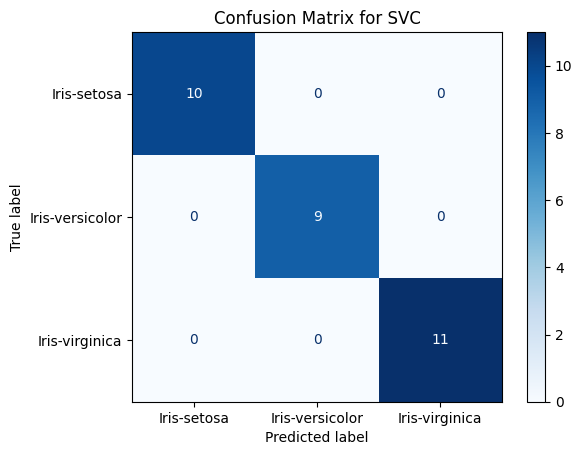

In [61]:
# example confusion matrix for report:
y_pred = optimized_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix for {best_model_name}")
plt.show()

So far, the model routing and multi-algorithm ML comparison seems to be working well. 
Next step is to create functions and methods for all of these to create an efficient pipeline.

In [62]:
# mimic the bare bones preprocessing steps:
file_path = '/Users/danmcgill/Desktop/SWENG 894/repos/sweng-capstone-project/test-data/auto-mpg.csv'
df = pd.read_csv(file_path)
print(df.head())

    mpg  cylinders  displacement horsepower  weight  acceleration  model year  \
0  18.0          8         307.0        130    3504          12.0          70   
1  15.0          8         350.0        165    3693          11.5          70   
2  18.0          8         318.0        150    3436          11.0          70   
3  16.0          8         304.0        150    3433          12.0          70   
4  17.0          8         302.0        140    3449          10.5          70   

   origin                   car name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino  


In [63]:
target_column = 'mpg'
X = df.drop(columns=[target_column, 'car name'])  
y = df[target_column]
print("Features:")
print(X.head())
print("Target:")
print(y.head())

Features:
   cylinders  displacement horsepower  weight  acceleration  model year  \
0          8         307.0        130    3504          12.0          70   
1          8         350.0        165    3693          11.5          70   
2          8         318.0        150    3436          11.0          70   
3          8         304.0        150    3433          12.0          70   
4          8         302.0        140    3449          10.5          70   

   origin  
0       1  
1       1  
2       1  
3       1  
4       1  
Target:
0    18.0
1    15.0
2    18.0
3    16.0
4    17.0
Name: mpg, dtype: float64


In [75]:
# create a prototype for preprocessing: 
numeric_features = ['displacement', 'horsepower', 'weight', 'acceleration', 'model year']
categorical_features = ['cylinders', 'origin']

# handle non-numeric
for col in numeric_features:
    X[col] = pd.to_numeric(X[col], errors='coerce')
valid_idx = X.dropna(subset=numeric_features).index
X = X.loc[valid_idx]
y = y.loc[valid_idx]

scaler = MinMaxScaler()
X_numeric_scaled = pd.DataFrame(scaler.fit_transform(X[numeric_features]), columns=numeric_features, index=X.index)
encoder = OneHotEncoder(drop='first', sparse_output=False) # drop first to prevent matrix singularity - generally ok but not neccesary for tree based models
X_cat_encoded = encoder.fit_transform(X[categorical_features])
encoded_feature_names = encoder.get_feature_names_out(categorical_features)
X_cat_encoded_df = pd.DataFrame(X_cat_encoded, columns=encoded_feature_names, index=X.index)
X_processed = pd.concat([X_numeric_scaled, X_cat_encoded_df], axis=1)
print("Processed features shape:", X_processed.shape)
print(X_processed.head())

Processed features shape: (392, 11)
   displacement  horsepower    weight  acceleration  model year  cylinders_4  \
0      0.617571    0.456522  0.536150      0.238095         0.0          0.0   
1      0.728682    0.646739  0.589736      0.208333         0.0          0.0   
2      0.645995    0.565217  0.516870      0.178571         0.0          0.0   
3      0.609819    0.565217  0.516019      0.238095         0.0          0.0   
4      0.604651    0.510870  0.520556      0.148810         0.0          0.0   

   cylinders_5  cylinders_6  cylinders_8  origin_2  origin_3  
0          0.0          0.0          1.0       0.0       0.0  
1          0.0          0.0          1.0       0.0       0.0  
2          0.0          0.0          1.0       0.0       0.0  
3          0.0          0.0          1.0       0.0       0.0  
4          0.0          0.0          1.0       0.0       0.0  


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [77]:
# function to return models based on 
def get_models(task_type: str):

    if task_type == 'classification':
        models = {
            'LogisticRegression': LogisticRegression(max_iter=1000),
            'RandomForestClassifier': RandomForestClassifier(),
            'GradientBoostingClassifier': GradientBoostingClassifier(),
            'SVC': SVC()
        }
    else:
        models = {
            'LinearRegression': LinearRegression(),
            'RandomForestRegressor': RandomForestRegressor(),
            'GradientBoostingRegressor': GradientBoostingRegressor(),
            'SVR': SVR()
        }
    return models

task_type = 'regression'  # or 'classification'
models = get_models(task_type)
print(list(models.keys()))

['LinearRegression', 'RandomForestRegressor', 'GradientBoostingRegressor', 'SVR']


In [83]:
def evaluate_models(models, X_train, y_train, task_type='classification', cv_folds=5):

    scoring = 'accuracy' if task_type == 'classification' else 'r2'
    model_scores = {}

    for name, model in models.items():
        scores = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring=scoring)
        model_scores[name] = scores
        print(f"{name} CV {scoring}: Mean={scores.mean():.3f} Std={scores.std():.3f}")

    best_model_name = max(model_scores, key=lambda k: model_scores[k].mean())
    print(f"\nBest model: {best_model_name} with mean {scoring} = {model_scores[best_model_name].mean():.3f}")

    return model_scores, best_model_name

model_scores, best_model_name = evaluate_models(models, X_train, y_train, task_type)
print("Best model returned:", best_model)

LinearRegression CV r2: Mean=0.818 Std=0.038
RandomForestRegressor CV r2: Mean=0.856 Std=0.030
GradientBoostingRegressor CV r2: Mean=0.856 Std=0.033
SVR CV r2: Mean=0.783 Std=0.019

Best model: RandomForestRegressor with mean r2 = 0.856
Best model returned: RandomForestRegressor


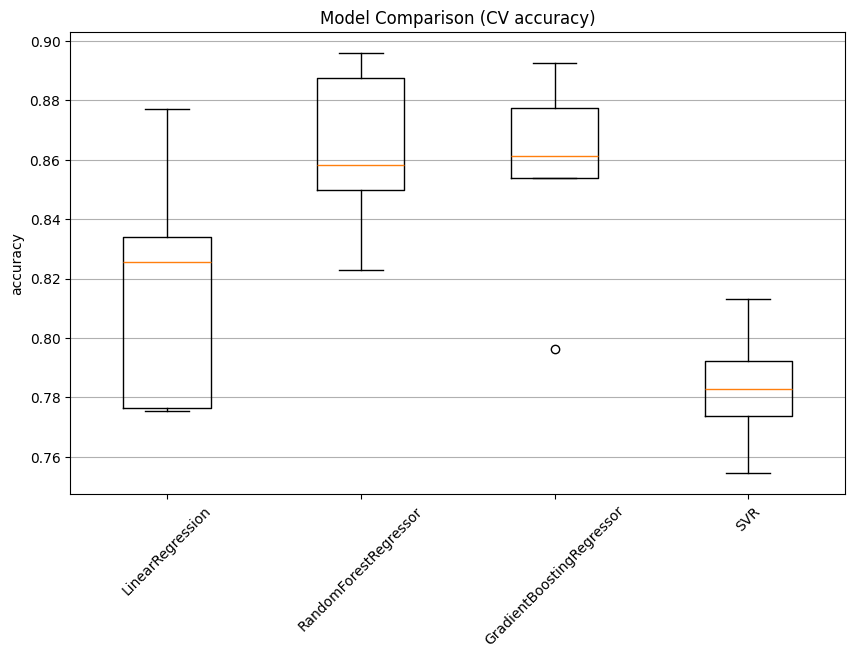

In [81]:
def plot_model_comparison(model_scores, task_type):

    scoring = 'accuracy' if task_type == 'classification' else 'r2'

    plt.figure(figsize=(10, 6))
    plt.boxplot(model_scores.values(), tick_labels=model_scores.keys())
    plt.title(f'Model Comparison (CV {scoring})')
    plt.ylabel(scoring)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

plot_model_comparison(model_scores, task_type='classification')


In [84]:
def tune_best_model(models, best_model_name, param_grids, X_train, y_train, task_type):

    scoring = 'accuracy' if task_type == 'classification' else 'r2'

    best_model = models[best_model_name]
    param_grid = param_grids.get(best_model_name, {})

    grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring=scoring, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print(f"Best params for {best_model_name}: {grid_search.best_params_}")
    print(f"Best CV {scoring} from GridSearch: {grid_search.best_score_}")

    return grid_search.best_estimator_

optimized_model = tune_best_model(models, best_model_name, param_grids, X_train, y_train, task_type)

Best params for RandomForestRegressor: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best CV r2 from GridSearch: 0.8636547773390714


In [86]:
def evaluate_final_model(model, X_train, y_train, X_test, y_test, task_type='classification'):

    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    if task_type == 'classification':
        train_score = accuracy_score(y_train, y_train_pred)
        test_score = accuracy_score(y_test, y_test_pred)
        metric_name = "Accuracy"
    else:  # regression
        train_score = r2_score(y_train, y_train_pred)
        test_score = r2_score(y_test, y_test_pred)
        metric_name = "R2 Score"
    
    print(f"Train {metric_name}: {train_score:.4f}")
    print(f"Test {metric_name}: {test_score:.4f}")
    
    return {'train_score': train_score, 'test_score': test_score}

results = evaluate_final_model(optimized_model, X_train, y_train, X_test, y_test, task_type='regression')


Train R2 Score: 0.9733
Test R2 Score: 0.8905


## Functions

- `get_models(task_type)` — returns models dictionary for classification or regression.  
- `evaluate_models(models, X_train, y_train, task_type)` — runs CV, prints scores, plots comparison, returns best model name.  
- `plot_model_comparison(model_scores, task_type)` — makes box plot of all models.  
- `tune_best_model(best_model_name, models, param_grids, X_train, y_train, task_type)` — runs GridSearchCV to optimize best model, returns optimized model.  
- `evaluate_final_model(model, X_train, y_train, X_test, y_test, task_type)` — fits model and prints train/test performance metrics.  